In [2]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Processing

In [3]:
#Open business.json file, create tsv file with business_id, business name, categories, and review count to be used as features 
#and stars as label

outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','categories', 'stars', 'review_count', 'postal code'])
with open('yelp_academic_dataset_business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['categories'], row['stars'], row['review_count'], row['postal_code']])

outfile.close()

business_df= pd.read_csv('business.tsv', delimiter ="\t")

In [4]:
#Open review.json file, create tsv file with business_id,text to be used as features 
#and stars as label

outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('yelp_academic_dataset_review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

review_df= pd.read_csv('review_stars.tsv', delimiter ="\t")

In [5]:
# Group all reviews by business_id
review_agg_df = review_df.groupby('business_id')['text'].sum()
review_df_ready_for_sklearn = pd.DataFrame({'business_id': review_agg_df.index, 'all_reviews': review_agg_df.values})

In [6]:
#Merge the resulting review aggregate dataframe with business dataframe
merge_df = pd.merge(business_df, review_df_ready_for_sklearn, on='business_id')

In [7]:
#Normalization of review count field so it becomes comparable and remove bias

from scipy.stats import zscore

merge_df.insert(3,'normalized_count',((merge_df['review_count'] - merge_df['review_count'].min()) / (merge_df['review_count'].max() - merge_df['review_count'].min())).astype(float))
merge_df['review_count'] = zscore(merge_df['review_count'])


In [8]:
# removing NaN categories

merge_df = merge_df[merge_df['categories'].notnull()]
merge_df = merge_df[0:10000]

In [9]:
# Extracting categories

from sklearn.preprocessing import MultiLabelBinarizer
encoded_categories = MultiLabelBinarizer()
category_matrix = encoded_categories.fit_transform(merge_df['categories'].str.split(','))

In [10]:
#TF-IDF calculation

tfidf = sk_text.TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,3))

In [11]:
# Fit the reviews column with TFIDFvectorizer
matrix = tfidf.fit_transform(merge_df['all_reviews'])
matrix = matrix.toarray()

In [12]:
# We are adding the normalized count to the original matrix with TFIDFvectorizer
x_matrix_minmax = np.column_stack((matrix, merge_df['normalized_count']))

# Zscore
x_matrix_zscore = np.column_stack((matrix, merge_df['review_count']))

In [13]:
#train test data for linear regression

x_train, x_test, y_train, y_test = train_test_split(x_matrix_minmax, merge_df['stars'] , test_size=0.2, random_state=42)

# Training and prediction using Regression

In [14]:
# linear regression

lin_reg_model = LinearRegression()

lin_reg_model.fit(x_train, y_train)

y_pred_linear = lin_reg_model.predict(x_test)

In [15]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test.index[i]
    print("business id - %s actual stars  - %f predicted - %f" 
          %(merge_df['business_id'][idx], y_test[idx], y_pred_linear[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars  - 4.000000 predicted - 3.643041
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars  - 4.000000 predicted - 3.900257
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars  - 4.000000 predicted - 4.197429
business id - jrhc4s5XMR8S8kpGdU08og actual stars  - 4.500000 predicted - 4.797609
business id - e7207sqC-pSn6GIf31ikhQ actual stars  - 4.000000 predicted - 3.765016
business id - CF9TxeEdP5QxihYFAl4sUg actual stars  - 4.000000 predicted - 4.057981
business id - zZPCAFK85NtitSNVP_wfYg actual stars  - 3.500000 predicted - 3.503671
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars  - 5.000000 predicted - 4.855848
business id - TTrYd662CZFRPaiwl-sUqA actual stars  - 2.000000 predicted - 1.747432
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars  - 2.500000 predicted - 2.484346


In [16]:
# RMS value

score_lin_classic = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print("Root Mean Squared Error: %.2f" % score_lin_classic)
print('R2 score: %.2f' % r2_score(y_test, y_pred_linear))

Root Mean Squared Error: 0.56
Variance score: 0.70


In [17]:
# label encoding data for logistic regression

label_encoder = preprocessing.LabelEncoder()

merge_df['encoded_stars'] = label_encoder.fit_transform(merge_df['stars'])

In [18]:
# train test data afor other models

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, merge_df['encoded_stars'] , test_size=0.2, random_state=42)

In [19]:
# logistic Regression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_train_lr, y_train_lr)

y_pred_logistic = Log_reg_model.predict(x_test_lr)


In [20]:
# RMs for logistic

score_log_classic = np.sqrt(mean_squared_error(y_test_lr, y_pred_logistic))
print("Root Mean Squared Error: %.2f" % score_log_classic)
print('R2 score: %.2f' % r2_score(y_test_lr, y_pred_logistic))


Root Mean Squared Error: 1.38
Variance score: 0.54


# Tensorflow Model for Regression

** Training without early stopping and Model Checkpoint and RELU **

In [21]:
#Tensor flow works well with 32 bit
y_stars_regression = merge_df['stars'].values.astype(np.float32)

In [22]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_minmax, y_stars_regression , test_size=0.2)


In [23]:
# Tensorflow model for Regression with RELU

model_reg_relu = Sequential()

model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
model_reg_relu.add(Dense(1)) # Output

In [24]:
#Model training with Optimizer = adam

model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
model_reg_relu.fit(x_train_reg,y_train_reg,verbose=2,epochs=100) 


Epoch 1/100
 - 1s - loss: 2.3512
Epoch 2/100
 - 1s - loss: 0.3952
Epoch 3/100
 - 1s - loss: 0.2887
Epoch 4/100
 - 1s - loss: 0.2576
Epoch 5/100
 - 0s - loss: 0.2426
Epoch 6/100
 - 0s - loss: 0.2266
Epoch 7/100
 - 0s - loss: 0.1978
Epoch 8/100
 - 1s - loss: 0.1676
Epoch 9/100
 - 1s - loss: 0.1418
Epoch 10/100
 - 0s - loss: 0.1168
Epoch 11/100
 - 0s - loss: 0.0960
Epoch 12/100
 - 0s - loss: 0.0802
Epoch 13/100
 - 0s - loss: 0.0677
Epoch 14/100
 - 0s - loss: 0.0578
Epoch 15/100
 - 0s - loss: 0.0479
Epoch 16/100
 - 0s - loss: 0.0415
Epoch 17/100
 - 0s - loss: 0.0363
Epoch 18/100
 - 0s - loss: 0.0314
Epoch 19/100
 - 0s - loss: 0.0275
Epoch 20/100
 - 0s - loss: 0.0246
Epoch 21/100
 - 0s - loss: 0.0222
Epoch 22/100
 - 0s - loss: 0.0206
Epoch 23/100
 - 0s - loss: 0.0201
Epoch 24/100
 - 0s - loss: 0.0195
Epoch 25/100
 - 1s - loss: 0.0184
Epoch 26/100
 - 1s - loss: 0.0169
Epoch 27/100
 - 0s - loss: 0.0169
Epoch 28/100
 - 0s - loss: 0.0160
Epoch 29/100
 - 0s - loss: 0.0154
Epoch 30/100
 - 0s - lo

In [25]:
# Predict stars
pred_reg_simple = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_simple.shape))


Shape: (2000, 1)


In [26]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [2.8022065]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 2.5, predicted Stars: [1.9806347]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 2.5, predicted Stars: [1.8916467]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.5, predicted Stars: [3.1011438]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [2.7952552]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 2.5, predicted Stars: [2.213677]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [1.9444847]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 3.0, predicted Stars: [3.5327148]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [3.4062147]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [2.4765658]


In [30]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_relu = np.sqrt(mean_squared_error(y_test_reg,pred_reg_simple))
print("Final score (RMSE): {}".format(score_reg_relu))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_simple))

Final score (RMSE): 0.5732024908065796
R2 score: 0.68


** Training with early stopping and Model Checkpoint ReLU **

In [82]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu.hdf5", verbose=1, save_best_only=True)

In [83]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 4s - loss: 1.9429 - val_loss: 0.4807

Epoch 00001: val_loss improved from inf to 0.48067, saving model to ./best_weights_relu.hdf5
Epoch 2/100
 - 2s - loss: 0.3239 - val_loss: 0.3785

Epoch 00002: val_loss improved from 0.48067 to 0.37852, saving model to ./best_weights_relu.hdf5
Epoch 3/100
 - 3s - loss: 0.2114 - val_loss: 0.3623

Epoch 00003: val_loss improved from 0.37852 to 0.36232, saving model to ./best_weights_relu.hdf5
Epoch 4/100
 - 2s - loss: 0.1640 - val_loss: 0.3665

Epoch 00004: val_loss did not improve from 0.36232
Epoch 5/100
 - 2s - loss: 0.1349 - val_loss: 0.3770

Epoch 00005: val_loss did not improve from 0.36232
Epoch 6/100
 - 2s - loss: 0.1122 - val_loss: 0.3892

Epoch 00006: val_loss did not improve from 0.36232
Epoch 7/100
 - 2s - loss: 0.0924 - val_loss: 0.3905

Epoch 00007: val_loss did not improve from 0.36232
Epoch 8/100
 - 3s - loss: 0.0724 - val_loss: 0.3866

Epoch 00008: val_loss did not impro

 - 3s - loss: 0.1484 - val_loss: 0.3774

Epoch 00005: val_loss did not improve from 0.35812
Epoch 6/100
 - 3s - loss: 0.1294 - val_loss: 0.3851

Epoch 00006: val_loss did not improve from 0.35812
Epoch 7/100
 - 3s - loss: 0.1089 - val_loss: 0.3818

Epoch 00007: val_loss did not improve from 0.35812
Epoch 8/100
 - 3s - loss: 0.0942 - val_loss: 0.3866

Epoch 00008: val_loss did not improve from 0.35812
Epoch 9/100
 - 3s - loss: 0.0790 - val_loss: 0.3872

Epoch 00009: val_loss did not improve from 0.35812
Epoch 00009: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 1.9894 - val_loss: 0.4869

Epoch 00001: val_loss did not improve from 0.35812
Epoch 2/100
 - 3s - loss: 0.3349 - val_loss: 0.3825

Epoch 00002: val_loss did not improve from 0.35812
Epoch 3/100
 - 3s - loss: 0.2182 - val_loss: 0.3780

Epoch 00003: val_loss did not improve from 0.35812
Epoch 4/100
 - 3s - loss: 0.1666 - val_loss: 0.3758

Epoch 00004: val_loss did not improve from 0.3581

In [84]:
# Predict stars
pred_reg_stopping = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_stopping.shape))

Shape: (2000, 1)


In [85]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 2.0, predicted Stars: [1.9188011]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 5.0, predicted Stars: [3.5073977]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [2.555329]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.5, predicted Stars: [3.6105719]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.0, predicted Stars: [2.5487258]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.5, predicted Stars: [5.296804]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 3.5, predicted Stars: [4.684453]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 3.5, predicted Stars: [3.2609322]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.428051]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [3.6865396]


In [86]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_relu_stopping = np.sqrt(mean_squared_error(y_test_reg,pred_reg_stopping))
print("Final score (RMSE): {}".format(score_reg_relu_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_stopping))

Final score (RMSE): 0.5984302163124084
R2 score: 0.66


# Relu with Postal Code and Categories

In [105]:
# one-hot cooding of postal codes 

postal_hotcoded_df = pd.get_dummies(merge_df['postal code'], sparse = 'true')

x_matrix_postal = np.column_stack((x_matrix_minmax, postal_hotcoded_df))
x_matrix_final = np.column_stack((x_matrix_postal, category_matrix))



In [106]:
print(y_stars_regression.shape)


(10000,)


In [107]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_final, y_stars_regression , test_size=0.2)

In [108]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_postal.hdf5", verbose=1, save_best_only=True)


In [109]:
#ReLU
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_postal.hdf5')


0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 1.8029 - val_loss: 0.4539

Epoch 00001: val_loss improved from inf to 0.45386, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 2/100
 - 3s - loss: 0.3086 - val_loss: 0.4007

Epoch 00002: val_loss improved from 0.45386 to 0.40070, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 3/100
 - 3s - loss: 0.2069 - val_loss: 0.3674

Epoch 00003: val_loss improved from 0.40070 to 0.36736, saving model to ./best_weights_sigmoid_postal.hdf5
Epoch 4/100
 - 3s - loss: 0.1602 - val_loss: 0.3862

Epoch 00004: val_loss did not improve from 0.36736
Epoch 5/100
 - 3s - loss: 0.1327 - val_loss: 0.3684

Epoch 00005: val_loss did not improve from 0.36736
Epoch 6/100
 - 4s - loss: 0.1090 - val_loss: 0.3869

Epoch 00006: val_loss did not improve from 0.36736
Epoch 7/100
 - 3s - loss: 0.0896 - val_loss: 0.3900

Epoch 00007: val_loss did not improve from 0.36736
Epoch 8/100
 - 3s - loss: 0.0733 - val_loss: 0.3955

Epoch

 - 3s - loss: 0.0784 - val_loss: 0.4044

Epoch 00007: val_loss did not improve from 0.36457
Epoch 8/100
 - 3s - loss: 0.0652 - val_loss: 0.4105

Epoch 00008: val_loss did not improve from 0.36457
Epoch 00008: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 1.8085 - val_loss: 0.4856

Epoch 00001: val_loss did not improve from 0.36457
Epoch 2/100
 - 3s - loss: 0.3166 - val_loss: 0.3809

Epoch 00002: val_loss did not improve from 0.36457
Epoch 3/100
 - 3s - loss: 0.2116 - val_loss: 0.3856

Epoch 00003: val_loss did not improve from 0.36457
Epoch 4/100
 - 3s - loss: 0.1661 - val_loss: 0.3712

Epoch 00004: val_loss did not improve from 0.36457
Epoch 5/100
 - 3s - loss: 0.1371 - val_loss: 0.3851

Epoch 00005: val_loss did not improve from 0.36457
Epoch 6/100
 - 3s - loss: 0.1129 - val_loss: 0.3854

Epoch 00006: val_loss did not improve from 0.36457
Epoch 7/100
 - 4s - loss: 0.0889 - val_loss: 0.3953

Epoch 00007: val_loss did not improve from 0.3645

 - 3s - loss: 0.1641 - val_loss: 0.2984

Epoch 00007: val_loss did not improve from 0.28959
Epoch 8/100
 - 4s - loss: 0.1513 - val_loss: 0.2979

Epoch 00008: val_loss did not improve from 0.28959
Epoch 9/100
 - 3s - loss: 0.1419 - val_loss: 0.2990

Epoch 00009: val_loss did not improve from 0.28959
Epoch 10/100
 - 3s - loss: 0.1321 - val_loss: 0.3127

Epoch 00010: val_loss did not improve from 0.28959
Epoch 11/100
 - 4s - loss: 0.1253 - val_loss: 0.3083

Epoch 00011: val_loss did not improve from 0.28959
Epoch 00011: early stopping
5
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 3.8595 - val_loss: 1.0628

Epoch 00001: val_loss did not improve from 0.28959
Epoch 2/100
 - 3s - loss: 1.0087 - val_loss: 0.9858

Epoch 00002: val_loss did not improve from 0.28959
Epoch 3/100
 - 4s - loss: 0.8965 - val_loss: 0.8220

Epoch 00003: val_loss did not improve from 0.28959
Epoch 4/100
 - 3s - loss: 0.6384 - val_loss: 0.5663

Epoch 00004: val_loss did not improve from 0.28

In [110]:
# Predict stars relu
pred_reg_relu_stopping = model_reg_relu.predict(x_test_reg)
print("Shape: {}".format(pred_reg_relu_stopping.shape))

Shape: (2000, 1)


In [111]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_relu_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [1.9188011]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.5073977]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [2.555329]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.6105719]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.5487258]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [5.296804]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [4.684453]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [3.2609322]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.428051]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [3.6865396]


In [112]:
score_relu_postal = np.sqrt(mean_squared_error(y_test_reg,pred_reg_relu_stopping))
print("Final score (RMSE) Sigmoid: {}".format(score_relu_postal))
print('R2 score Sigmoid: %.2f' % r2_score(y_test_reg, pred_reg_relu_stopping))

Final score (RMSE) ReLU: 0.2876877188682556
R2 score Relu: 0.92
Final score (RMSE) ReLU: 0.2876877188682556
R2 score Relu: 0.92


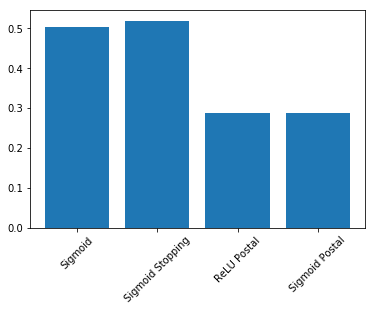

In [113]:
# Best from classic, best from tensor flow and additional features comparison

score_list_reg=[score_reg_sig,score_reg_sig_stopping, score_relu_postal]
names =['Sigmoid','Sigmoid Stopping','ReLU Postal']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Experimenting with different optimizers for ReLU

** SGD **

In [114]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_sgd.hdf5", verbose=1, save_best_only=True)

In [115]:
#Model training with Stochastic gradient descent optimizer(SGD).
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_sgd.hdf5')


0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 1.2416 - val_loss: 0.7421

Epoch 00001: val_loss improved from inf to 0.74209, saving model to ./best_weights_relu_sgd.hdf5
Epoch 2/100
 - 2s - loss: 0.5746 - val_loss: 0.4747

Epoch 00002: val_loss improved from 0.74209 to 0.47469, saving model to ./best_weights_relu_sgd.hdf5
Epoch 3/100
 - 3s - loss: 0.3808 - val_loss: 0.3859

Epoch 00003: val_loss improved from 0.47469 to 0.38587, saving model to ./best_weights_relu_sgd.hdf5
Epoch 4/100
 - 2s - loss: 0.3110 - val_loss: 0.3493

Epoch 00004: val_loss improved from 0.38587 to 0.34927, saving model to ./best_weights_relu_sgd.hdf5
Epoch 5/100
 - 2s - loss: 0.2799 - val_loss: 0.3404

Epoch 00005: val_loss improved from 0.34927 to 0.34043, saving model to ./best_weights_relu_sgd.hdf5
Epoch 6/100
 - 2s - loss: 0.2583 - val_loss: 0.3336

Epoch 00006: val_loss improved from 0.34043 to 0.33358, saving model to ./best_weights_relu_sgd.hdf5
Epoch 7/100
 - 3s - loss: 0.24


Epoch 00005: val_loss did not improve from 0.31992
Epoch 6/100
 - 2s - loss: 0.2676 - val_loss: 0.3385

Epoch 00006: val_loss did not improve from 0.31992
Epoch 7/100
 - 3s - loss: 0.2491 - val_loss: 0.3319

Epoch 00007: val_loss did not improve from 0.31992
Epoch 8/100
 - 2s - loss: 0.2336 - val_loss: 0.3306

Epoch 00008: val_loss did not improve from 0.31992
Epoch 9/100
 - 2s - loss: 0.2229 - val_loss: 0.3271

Epoch 00009: val_loss did not improve from 0.31992
Epoch 10/100
 - 2s - loss: 0.2118 - val_loss: 0.3341

Epoch 00010: val_loss did not improve from 0.31992
Epoch 11/100
 - 2s - loss: 0.2025 - val_loss: 0.3257

Epoch 00011: val_loss did not improve from 0.31992
Epoch 12/100
 - 3s - loss: 0.1949 - val_loss: 0.3389

Epoch 00012: val_loss did not improve from 0.31992
Epoch 13/100
 - 2s - loss: 0.1859 - val_loss: 0.3291

Epoch 00013: val_loss did not improve from 0.31992
Epoch 14/100
 - 2s - loss: 0.1806 - val_loss: 0.3237

Epoch 00014: val_loss did not improve from 0.31992
Epoch 1

 - 2s - loss: 0.1896 - val_loss: 0.3180

Epoch 00012: val_loss improved from 0.31856 to 0.31801, saving model to ./best_weights_relu_sgd.hdf5
Epoch 13/100
 - 2s - loss: 0.1819 - val_loss: 0.3196

Epoch 00013: val_loss did not improve from 0.31801
Epoch 14/100
 - 3s - loss: 0.1748 - val_loss: 0.3181

Epoch 00014: val_loss did not improve from 0.31801
Epoch 15/100
 - 2s - loss: 0.1673 - val_loss: 0.3213

Epoch 00015: val_loss did not improve from 0.31801
Epoch 16/100
 - 2s - loss: 0.1621 - val_loss: 0.3158

Epoch 00016: val_loss improved from 0.31801 to 0.31576, saving model to ./best_weights_relu_sgd.hdf5
Epoch 17/100
 - 2s - loss: 0.1553 - val_loss: 0.3227

Epoch 00017: val_loss did not improve from 0.31576
Epoch 18/100
 - 3s - loss: 0.1506 - val_loss: 0.3285

Epoch 00018: val_loss did not improve from 0.31576
Epoch 19/100
 - 3s - loss: 0.1454 - val_loss: 0.3212

Epoch 00019: val_loss did not improve from 0.31576
Epoch 20/100
 - 2s - loss: 0.1404 - val_loss: 0.3196

Epoch 00020: val_lo

In [116]:
# Predict stars
pred_reg_sgd = model_reg_relu.predict(x_test_reg)

In [117]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sgd[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [5.1745205]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.7011952]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.7546391]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.8918414]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.5711584]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [3.4422555]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [4.1195154]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.2732162]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [3.8707886]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [4.8203497]


In [118]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_sgd = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sgd))
print("Final score (RMSE): {}".format(score_relu_sgd))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sgd))

Final score (RMSE): 0.5619208812713623
R2 score: 0.69


** RMSProp **

In [119]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_rmsprop.hdf5", verbose=1, save_best_only=True)

In [120]:
#Model training with RMSProp optimizer.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_rmsprop.hdf5')


0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 1.3005 - val_loss: 0.3905

Epoch 00001: val_loss improved from inf to 0.39054, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 2/100
 - 3s - loss: 0.2986 - val_loss: 0.3437

Epoch 00002: val_loss improved from 0.39054 to 0.34370, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 3/100
 - 3s - loss: 0.2378 - val_loss: 0.3331

Epoch 00003: val_loss improved from 0.34370 to 0.33305, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 4/100
 - 3s - loss: 0.2080 - val_loss: 0.3729

Epoch 00004: val_loss did not improve from 0.33305
Epoch 5/100
 - 3s - loss: 0.1817 - val_loss: 0.3449

Epoch 00005: val_loss did not improve from 0.33305
Epoch 6/100
 - 4s - loss: 0.1603 - val_loss: 0.3332

Epoch 00006: val_loss did not improve from 0.33305
Epoch 7/100
 - 3s - loss: 0.1369 - val_loss: 0.3289

Epoch 00007: val_loss improved from 0.33305 to 0.32887, saving model to ./best_weights_relu_rmsprop.hdf5
Epoch 8/10

 - 3s - loss: 0.1035 - val_loss: 0.3361

Epoch 00008: val_loss did not improve from 0.31510
Epoch 9/100
 - 3s - loss: 0.0847 - val_loss: 0.3201

Epoch 00009: val_loss did not improve from 0.31510
Epoch 10/100
 - 3s - loss: 0.0705 - val_loss: 0.3243

Epoch 00010: val_loss did not improve from 0.31510
Epoch 11/100
 - 3s - loss: 0.0601 - val_loss: 0.3535

Epoch 00011: val_loss did not improve from 0.31510
Epoch 12/100
 - 3s - loss: 0.0509 - val_loss: 0.3357

Epoch 00012: val_loss did not improve from 0.31510
Epoch 00012: early stopping
6
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 1.2305 - val_loss: 0.3863

Epoch 00001: val_loss did not improve from 0.31510
Epoch 2/100
 - 3s - loss: 0.2967 - val_loss: 0.3532

Epoch 00002: val_loss did not improve from 0.31510
Epoch 3/100
 - 4s - loss: 0.2400 - val_loss: 0.3319

Epoch 00003: val_loss did not improve from 0.31510
Epoch 4/100
 - 3s - loss: 0.2073 - val_loss: 0.3367

Epoch 00004: val_loss did not improve from 0.3

In [121]:
# Predict stars
pred_reg_rmsprop = model_reg_relu.predict(x_test_reg)

In [122]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_rmsprop[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [4.869574]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.5951164]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.4641051]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [4.3006268]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.5696065]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [4.589199]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.747323]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.2644005]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.4606256]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [4.549286]


In [123]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_rmsprop = np.sqrt(mean_squared_error(y_test_reg,pred_reg_rmsprop))
print("Final score (RMSE): {}".format(score_relu_rmsprop))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_rmsprop))

Final score (RMSE): 0.5563821196556091
R2 score: 0.70


** Adagrad **

In [124]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adagrad.hdf5", verbose=1, save_best_only=True)

In [125]:
#Model training with Adagrad.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adagrad')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_adagrad.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 0.7942 - val_loss: 0.4038

Epoch 00001: val_loss improved from inf to 0.40379, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 2/100
 - 3s - loss: 0.2672 - val_loss: 0.3663

Epoch 00002: val_loss improved from 0.40379 to 0.36630, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 3/100
 - 3s - loss: 0.2009 - val_loss: 0.3595

Epoch 00003: val_loss improved from 0.36630 to 0.35953, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 4/100
 - 3s - loss: 0.1650 - val_loss: 0.3488

Epoch 00004: val_loss improved from 0.35953 to 0.34880, saving model to ./best_weights_relu_adagrad.hdf5
Epoch 5/100
 - 3s - loss: 0.1379 - val_loss: 0.3518

Epoch 00005: val_loss did not improve from 0.34880
Epoch 6/100
 - 3s - loss: 0.1154 - val_loss: 0.3522

Epoch 00006: val_loss did not improve from 0.34880
Epoch 7/100
 - 3s - loss: 0.0954 - val_loss: 0.3556

Epoch 00007: val_loss did not improve from 0.34880
Epoch 8/10

 - 3s - loss: 0.1681 - val_loss: 0.3542

Epoch 00004: val_loss did not improve from 0.34092
Epoch 5/100
 - 3s - loss: 0.1422 - val_loss: 0.3594

Epoch 00005: val_loss did not improve from 0.34092
Epoch 6/100
 - 3s - loss: 0.1209 - val_loss: 0.3565

Epoch 00006: val_loss did not improve from 0.34092
Epoch 7/100
 - 3s - loss: 0.1028 - val_loss: 0.3591

Epoch 00007: val_loss did not improve from 0.34092
Epoch 8/100
 - 3s - loss: 0.0870 - val_loss: 0.3575

Epoch 00008: val_loss did not improve from 0.34092
Epoch 9/100
 - 3s - loss: 0.0725 - val_loss: 0.3589

Epoch 00009: val_loss did not improve from 0.34092
Epoch 00009: early stopping
8
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 0.8217 - val_loss: 0.4295

Epoch 00001: val_loss did not improve from 0.34092
Epoch 2/100
 - 3s - loss: 0.2672 - val_loss: 0.3649

Epoch 00002: val_loss did not improve from 0.34092
Epoch 3/100
 - 4s - loss: 0.1977 - val_loss: 0.3559

Epoch 00003: val_loss did not improve from 0.3409

In [126]:
# Predict stars
pred_reg_adagrad = model_reg_relu.predict(x_test_reg)

In [127]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adagrad[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [5.160581]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.2411199]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.7054992]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.724305]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.3649683]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [3.6233296]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [4.0357356]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.4179277]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.2212996]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [4.939703]


In [128]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adagrad = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adagrad))
print("Final score (RMSE): {}".format(score_relu_adagrad))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adagrad))

Final score (RMSE): 0.5838866233825684
R2 score: 0.67


** Adadelta **

In [129]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adadelta.hdf5", verbose=1, save_best_only=True)

In [130]:
#Model training with ADadelta.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adadelta')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_adadelta.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 9s - loss: 0.9989 - val_loss: 0.3713

Epoch 00001: val_loss improved from inf to 0.37126, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 2/100
 - 4s - loss: 0.2822 - val_loss: 0.3283

Epoch 00002: val_loss improved from 0.37126 to 0.32831, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 3/100
 - 3s - loss: 0.2366 - val_loss: 0.3231

Epoch 00003: val_loss improved from 0.32831 to 0.32309, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 4/100
 - 4s - loss: 0.2054 - val_loss: 0.3182

Epoch 00004: val_loss improved from 0.32309 to 0.31824, saving model to ./best_weights_relu_adadelta.hdf5
Epoch 5/100
 - 4s - loss: 0.1818 - val_loss: 0.3219

Epoch 00005: val_loss did not improve from 0.31824
Epoch 6/100
 - 4s - loss: 0.1564 - val_loss: 0.3382

Epoch 00006: val_loss did not improve from 0.31824
Epoch 7/100
 - 4s - loss: 0.1297 - val_loss: 0.3245

Epoch 00007: val_loss did not improve from 0.31824
Epoch 


Epoch 00002: val_loss did not improve from 0.30893
Epoch 3/100
 - 4s - loss: 0.2344 - val_loss: 0.3235

Epoch 00003: val_loss did not improve from 0.30893
Epoch 4/100
 - 4s - loss: 0.2047 - val_loss: 0.3213

Epoch 00004: val_loss did not improve from 0.30893
Epoch 5/100
 - 3s - loss: 0.1813 - val_loss: 0.3268

Epoch 00005: val_loss did not improve from 0.30893
Epoch 6/100
 - 4s - loss: 0.1540 - val_loss: 0.3499

Epoch 00006: val_loss did not improve from 0.30893
Epoch 7/100
 - 4s - loss: 0.1278 - val_loss: 0.3217

Epoch 00007: val_loss did not improve from 0.30893
Epoch 8/100
 - 4s - loss: 0.1016 - val_loss: 0.3235

Epoch 00008: val_loss did not improve from 0.30893
Epoch 9/100
 - 4s - loss: 0.0824 - val_loss: 0.3323

Epoch 00009: val_loss did not improve from 0.30893
Epoch 00009: early stopping
8
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 8s - loss: 1.1903 - val_loss: 0.3556

Epoch 00001: val_loss did not improve from 0.30893
Epoch 2/100
 - 4s - loss: 0.2789 - val

In [131]:
# Predict stars
pred_reg_adadelta = model_reg_relu.predict(x_test_reg)

In [132]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adadelta[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [4.974571]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.7325032]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.4754226]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [4.126101]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.6592624]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [4.0764556]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.7106316]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.1212463]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.017893]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [5.124168]


In [133]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adadelta = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adadelta))
print("Final score (RMSE): {}".format(score_relu_adadelta))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adadelta))

Final score (RMSE): 0.5558121800422668
R2 score: 0.70


** Adamax **

In [134]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adamax.hdf5", verbose=1, save_best_only=True)

In [135]:
#Model training with Adamax.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adamax')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_adamax.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 8s - loss: 1.9869 - val_loss: 0.5466

Epoch 00001: val_loss improved from inf to 0.54659, saving model to ./best_weights_relu_adamax.hdf5
Epoch 2/100
 - 3s - loss: 0.3767 - val_loss: 0.3788

Epoch 00002: val_loss improved from 0.54659 to 0.37875, saving model to ./best_weights_relu_adamax.hdf5
Epoch 3/100
 - 4s - loss: 0.2703 - val_loss: 0.3358

Epoch 00003: val_loss improved from 0.37875 to 0.33576, saving model to ./best_weights_relu_adamax.hdf5
Epoch 4/100
 - 4s - loss: 0.2252 - val_loss: 0.3219

Epoch 00004: val_loss improved from 0.33576 to 0.32185, saving model to ./best_weights_relu_adamax.hdf5
Epoch 5/100
 - 3s - loss: 0.1985 - val_loss: 0.3211

Epoch 00005: val_loss improved from 0.32185 to 0.32111, saving model to ./best_weights_relu_adamax.hdf5
Epoch 6/100
 - 4s - loss: 0.1783 - val_loss: 0.3258

Epoch 00006: val_loss did not improve from 0.32111
Epoch 7/100
 - 4s - loss: 0.1631 - val_loss: 0.3297

Epoch 00007:


Epoch 00004: val_loss did not improve from 0.31894
Epoch 5/100
 - 3s - loss: 0.1978 - val_loss: 0.3265

Epoch 00005: val_loss did not improve from 0.31894
Epoch 6/100
 - 4s - loss: 0.1805 - val_loss: 0.3545

Epoch 00006: val_loss did not improve from 0.31894
Epoch 7/100
 - 4s - loss: 0.1676 - val_loss: 0.3366

Epoch 00007: val_loss did not improve from 0.31894
Epoch 8/100
 - 3s - loss: 0.1531 - val_loss: 0.3362

Epoch 00008: val_loss did not improve from 0.31894
Epoch 9/100
 - 5s - loss: 0.1406 - val_loss: 0.3454

Epoch 00009: val_loss did not improve from 0.31894
Epoch 10/100
 - 4s - loss: 0.1304 - val_loss: 0.3498

Epoch 00010: val_loss did not improve from 0.31894
Epoch 00010: early stopping
8
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 9s - loss: 1.5268 - val_loss: 0.4584

Epoch 00001: val_loss did not improve from 0.31894
Epoch 2/100
 - 4s - loss: 0.3270 - val_loss: 0.3523

Epoch 00002: val_loss did not improve from 0.31894
Epoch 3/100
 - 3s - loss: 0.2445 - va

In [136]:
# Predict stars
pred_reg_adamax = model_reg_relu.predict(x_test_reg)

In [137]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_adamax[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [5.135452]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.3520615]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.5837724]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.8185892]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.4812694]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [3.5921934]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [4.378864]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.225172]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.2369123]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [5.0254517]


In [138]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_adamax = np.sqrt(mean_squared_error(y_test_reg,pred_reg_adamax))
print("Final score (RMSE): {}".format(score_relu_adamax))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_adamax))

Final score (RMSE): 0.5647493004798889
R2 score: 0.69


** Nadam **

In [139]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_nadam.hdf5", verbose=1, save_best_only=True)

In [140]:
#Model training with Nadam.

for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu')) 
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='nadam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_nadam.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 10s - loss: 1.0294 - val_loss: 0.4501

Epoch 00001: val_loss improved from inf to 0.45008, saving model to ./best_weights_relu_nadam.hdf5
Epoch 2/100
 - 4s - loss: 0.2728 - val_loss: 0.3973

Epoch 00002: val_loss improved from 0.45008 to 0.39729, saving model to ./best_weights_relu_nadam.hdf5
Epoch 3/100
 - 4s - loss: 0.1900 - val_loss: 0.3872

Epoch 00003: val_loss improved from 0.39729 to 0.38720, saving model to ./best_weights_relu_nadam.hdf5
Epoch 4/100
 - 5s - loss: 0.1520 - val_loss: 0.3910

Epoch 00004: val_loss did not improve from 0.38720
Epoch 5/100
 - 4s - loss: 0.1151 - val_loss: 0.3846

Epoch 00005: val_loss improved from 0.38720 to 0.38461, saving model to ./best_weights_relu_nadam.hdf5
Epoch 6/100
 - 5s - loss: 0.0930 - val_loss: 0.3962

Epoch 00006: val_loss did not improve from 0.38461
Epoch 7/100
 - 4s - loss: 0.0761 - val_loss: 0.3958

Epoch 00007: val_loss did not improve from 0.38461
Epoch 8/100
 - 4s

 - 4s - loss: 0.0244 - val_loss: 0.3530

Epoch 00012: val_loss improved from 0.35840 to 0.35298, saving model to ./best_weights_relu_nadam.hdf5
Epoch 13/100
 - 4s - loss: 0.0232 - val_loss: 0.3622

Epoch 00013: val_loss did not improve from 0.35298
Epoch 14/100
 - 4s - loss: 0.0214 - val_loss: 0.3544

Epoch 00014: val_loss did not improve from 0.35298
Epoch 15/100
 - 4s - loss: 0.0213 - val_loss: 0.3520

Epoch 00015: val_loss improved from 0.35298 to 0.35197, saving model to ./best_weights_relu_nadam.hdf5
Epoch 16/100
 - 5s - loss: 0.0204 - val_loss: 0.3559

Epoch 00016: val_loss did not improve from 0.35197
Epoch 17/100
 - 4s - loss: 0.0202 - val_loss: 0.3540

Epoch 00017: val_loss did not improve from 0.35197
Epoch 18/100
 - 4s - loss: 0.0189 - val_loss: 0.3572

Epoch 00018: val_loss did not improve from 0.35197
Epoch 19/100
 - 4s - loss: 0.0184 - val_loss: 0.3472

Epoch 00019: val_loss improved from 0.35197 to 0.34724, saving model to ./best_weights_relu_nadam.hdf5
Epoch 20/100
 - 4

In [141]:
# Predict stars
pred_reg_nadam = model_reg_relu.predict(x_test_reg)

In [142]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_nadam[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [4.8099]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.1851962]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.6482627]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.824267]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.6786616]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [4.060901]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.7193618]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [3.8800077]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.365294]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [4.80472]


In [143]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_nadam = np.sqrt(mean_squared_error(y_test_reg,pred_reg_nadam))
print("Final score (RMSE): {}".format(score_relu_nadam))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_nadam))

Final score (RMSE): 0.5831780433654785
R2 score: 0.67


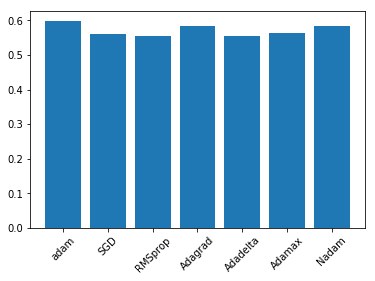

In [167]:
#Plot to show the best optimizer

score_list_reg_opt=[score_reg_relu_stopping,score_relu_sgd,score_relu_rmsprop, score_relu_adagrad,score_relu_adadelta,score_relu_adamax,score_relu_nadam]
names =['adam','SGD','RMSprop','Adagrad', 'Adadelta','Adamax','Nadam']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg_opt)), score_list_reg_opt)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Experiments with Hidden nodes selection in hidden layer 

** 2hidden Layers with adam optimizer**

In [145]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_2l.hdf5", verbose=1, save_best_only=True)

In [146]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_2l.hdf5')



0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 11s - loss: 2.1888 - val_loss: 0.4819

Epoch 00001: val_loss improved from inf to 0.48191, saving model to ./best_weights_relu_2l.hdf5
Epoch 2/100
 - 5s - loss: 0.3219 - val_loss: 0.3737

Epoch 00002: val_loss improved from 0.48191 to 0.37369, saving model to ./best_weights_relu_2l.hdf5
Epoch 3/100
 - 4s - loss: 0.2126 - val_loss: 0.3666

Epoch 00003: val_loss improved from 0.37369 to 0.36657, saving model to ./best_weights_relu_2l.hdf5
Epoch 4/100
 - 5s - loss: 0.1606 - val_loss: 0.3748

Epoch 00004: val_loss did not improve from 0.36657
Epoch 5/100
 - 4s - loss: 0.1287 - val_loss: 0.3757

Epoch 00005: val_loss did not improve from 0.36657
Epoch 6/100
 - 5s - loss: 0.1010 - val_loss: 0.3960

Epoch 00006: val_loss did not improve from 0.36657
Epoch 7/100
 - 4s - loss: 0.0813 - val_loss: 0.3934

Epoch 00007: val_loss did not improve from 0.36657
Epoch 8/100
 - 4s - loss: 0.0672 - val_loss: 0.3998

Epoch 00008: val_loss did


Epoch 00004: val_loss did not improve from 0.36625
Epoch 5/100
 - 4s - loss: 0.1465 - val_loss: 0.3677

Epoch 00005: val_loss did not improve from 0.36625
Epoch 6/100
 - 5s - loss: 0.1195 - val_loss: 0.3819

Epoch 00006: val_loss did not improve from 0.36625
Epoch 7/100
 - 4s - loss: 0.0969 - val_loss: 0.3968

Epoch 00007: val_loss did not improve from 0.36625
Epoch 8/100
 - 5s - loss: 0.0788 - val_loss: 0.4097

Epoch 00008: val_loss did not improve from 0.36625
Epoch 9/100
 - 5s - loss: 0.0644 - val_loss: 0.4053

Epoch 00009: val_loss did not improve from 0.36625
Epoch 10/100
 - 4s - loss: 0.0516 - val_loss: 0.4105

Epoch 00010: val_loss did not improve from 0.36625
Epoch 00010: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 11s - loss: 2.4323 - val_loss: 0.5123

Epoch 00001: val_loss did not improve from 0.36625
Epoch 2/100
 - 4s - loss: 0.3400 - val_loss: 0.3877

Epoch 00002: val_loss did not improve from 0.36625
Epoch 3/100
 - 4s - loss: 0.2177 - v

In [147]:
# Predict stars
pred_reg_hl = model_reg_relu.predict(x_test_reg)

In [148]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [5.1049814]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.080085]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.9044344]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.6088371]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.4052281]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [3.6562648]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.7468283]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.2008286]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [3.9779196]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [5.1368737]


In [149]:
# Measure RMSE error.  RMSE is common for regression.
score_2l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl))
print("Final score (RMSE): {}".format(score_2l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl))

Final score (RMSE): 0.6047360897064209
R2 score: 0.65


** 3Hidden Layers with adam optimizer**

In [150]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_3l.hdf5", verbose=1, save_best_only=True)

In [152]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(60, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_3l.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 8s - loss: 1.9458 - val_loss: 0.4450

Epoch 00001: val_loss improved from inf to 0.44500, saving model to ./best_weights_relu_3l.hdf5
Epoch 2/100
 - 4s - loss: 0.2989 - val_loss: 0.3853

Epoch 00002: val_loss improved from 0.44500 to 0.38528, saving model to ./best_weights_relu_3l.hdf5
Epoch 3/100
 - 4s - loss: 0.2016 - val_loss: 0.3664

Epoch 00003: val_loss improved from 0.38528 to 0.36638, saving model to ./best_weights_relu_3l.hdf5
Epoch 4/100
 - 4s - loss: 0.1599 - val_loss: 0.3820

Epoch 00004: val_loss did not improve from 0.36638
Epoch 5/100
 - 4s - loss: 0.1339 - val_loss: 0.3856

Epoch 00005: val_loss did not improve from 0.36638
Epoch 6/100
 - 4s - loss: 0.1102 - val_loss: 0.3864

Epoch 00006: val_loss did not improve from 0.36638
Epoch 7/100
 - 4s - loss: 0.0907 - val_loss: 0.3856

Epoch 00007: val_loss did not improve from 0.36638
Epoch 8/100
 - 4s - loss: 0.0712 - val_loss: 0.3929

Epoch 00008: val_loss did 

 - 4s - loss: 0.2095 - val_loss: 0.3693

Epoch 00003: val_loss did not improve from 0.35702
Epoch 4/100
 - 5s - loss: 0.1662 - val_loss: 0.3702

Epoch 00004: val_loss did not improve from 0.35702
Epoch 5/100
 - 5s - loss: 0.1406 - val_loss: 0.3859

Epoch 00005: val_loss did not improve from 0.35702
Epoch 6/100
 - 5s - loss: 0.1196 - val_loss: 0.3882

Epoch 00006: val_loss did not improve from 0.35702
Epoch 7/100
 - 4s - loss: 0.1006 - val_loss: 0.4071

Epoch 00007: val_loss did not improve from 0.35702
Epoch 8/100
 - 5s - loss: 0.0833 - val_loss: 0.4040

Epoch 00008: val_loss did not improve from 0.35702
Epoch 00008: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 12s - loss: 1.9426 - val_loss: 0.4705

Epoch 00001: val_loss did not improve from 0.35702
Epoch 2/100
 - 5s - loss: 0.3055 - val_loss: 0.3833

Epoch 00002: val_loss did not improve from 0.35702
Epoch 3/100
 - 5s - loss: 0.2020 - val_loss: 0.3668

Epoch 00003: val_loss did not improve from 0.357

In [153]:
# Predict stars
pred_reg_hl_3 = model_reg_relu.predict(x_test_reg)

In [154]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_3[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [5.2718616]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.1741922]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.6310928]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.4487543]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.2593913]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [3.4350264]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [4.284658]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.292638]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [3.9689474]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [4.7773023]


In [155]:
# Measure RMSE error.  RMSE is common for regression.
score_3l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_3))
print("Final score (RMSE): {}".format(score_3l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_3))

Final score (RMSE): 0.59750896692276
R2 score: 0.65


** 4 Hidden Layers with adam optimizer**

In [156]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_4l.hdf5", verbose=1, save_best_only=True)

In [157]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(80, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(20, activation='relu')) # Hidden 3
    model_reg_relu.add(Dense(10, activation='relu')) # Hidden 4
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 12s - loss: 1.9063 - val_loss: 0.4375

Epoch 00001: val_loss improved from inf to 0.43747, saving model to ./best_weights_relu_4l.hdf5
Epoch 2/100
 - 6s - loss: 0.2913 - val_loss: 0.3691

Epoch 00002: val_loss improved from 0.43747 to 0.36909, saving model to ./best_weights_relu_4l.hdf5
Epoch 3/100
 - 5s - loss: 0.1988 - val_loss: 0.3569

Epoch 00003: val_loss improved from 0.36909 to 0.35688, saving model to ./best_weights_relu_4l.hdf5
Epoch 4/100
 - 6s - loss: 0.1492 - val_loss: 0.3763

Epoch 00004: val_loss did not improve from 0.35688
Epoch 5/100
 - 5s - loss: 0.1203 - val_loss: 0.3795

Epoch 00005: val_loss did not improve from 0.35688
Epoch 6/100
 - 5s - loss: 0.0914 - val_loss: 0.3872

Epoch 00006: val_loss did not improve from 0.35688
Epoch 7/100
 - 5s - loss: 0.0709 - val_loss: 0.3906

Epoch 00007: val_loss did not improve from 0.35688
Epoch 8/100
 - 5s - loss: 0.0547 - val_loss: 0.4079

Epoch 00008: val_loss did


Epoch 00007: val_loss did not improve from 0.35547
Epoch 8/100
 - 5s - loss: 0.0563 - val_loss: 0.3970

Epoch 00008: val_loss did not improve from 0.35547
Epoch 00008: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 11s - loss: 2.5644 - val_loss: 0.4593

Epoch 00001: val_loss did not improve from 0.35547
Epoch 2/100
 - 5s - loss: 0.3021 - val_loss: 0.3750

Epoch 00002: val_loss did not improve from 0.35547
Epoch 3/100
 - 5s - loss: 0.2018 - val_loss: 0.3776

Epoch 00003: val_loss did not improve from 0.35547
Epoch 4/100
 - 5s - loss: 0.1547 - val_loss: 0.3827

Epoch 00004: val_loss did not improve from 0.35547
Epoch 5/100
 - 5s - loss: 0.1254 - val_loss: 0.3695

Epoch 00005: val_loss did not improve from 0.35547
Epoch 6/100
 - 5s - loss: 0.0986 - val_loss: 0.3783

Epoch 00006: val_loss did not improve from 0.35547
Epoch 7/100
 - 5s - loss: 0.0778 - val_loss: 0.3943

Epoch 00007: val_loss did not improve from 0.35547
Epoch 8/100
 - 5s - loss: 0.0611 - va

In [158]:
# Predict stars
pred_reg_hl_4 = model_reg_relu.predict(x_test_reg)

In [159]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_4[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [5.252351]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.4988868]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.5443144]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.8369918]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.366735]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [4.0126057]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.7982235]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.000417]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.149415]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [5.051223]


In [160]:
# Measure RMSE error.  RMSE is common for regression.
score_4l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_4))
print("Final score (RMSE): {}".format(score_4l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_4))

Final score (RMSE): 0.5962139368057251
R2 score: 0.66


** 5 Hidden Layers with adam optimizer**

In [161]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_5l.hdf5", verbose=1, save_best_only=True)

In [162]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()

    model_reg_relu.add(Dense(80, input_dim=x_train_reg.shape[1], activation='relu'))  
    model_reg_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_reg_relu.add(Dense(40, activation='relu')) # Hidden 3
    model_reg_relu.add(Dense(20, activation='relu')) # Hidden 4
    model_reg_relu.add(Dense(10, activation='relu')) # Hidden 5
    model_reg_relu.add(Dense(1)) # Output
    model_reg_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_5l.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 12s - loss: 1.9864 - val_loss: 0.4081

Epoch 00001: val_loss improved from inf to 0.40809, saving model to ./best_weights_relu_5l.hdf5
Epoch 2/100
 - 5s - loss: 0.2877 - val_loss: 0.3979

Epoch 00002: val_loss improved from 0.40809 to 0.39790, saving model to ./best_weights_relu_5l.hdf5
Epoch 3/100
 - 5s - loss: 0.1908 - val_loss: 0.3631

Epoch 00003: val_loss improved from 0.39790 to 0.36306, saving model to ./best_weights_relu_5l.hdf5
Epoch 4/100
 - 6s - loss: 0.1459 - val_loss: 0.3667

Epoch 00004: val_loss did not improve from 0.36306
Epoch 5/100
 - 6s - loss: 0.1131 - val_loss: 0.3980

Epoch 00005: val_loss did not improve from 0.36306
Epoch 6/100
 - 5s - loss: 0.0855 - val_loss: 0.3769

Epoch 00006: val_loss did not improve from 0.36306
Epoch 7/100
 - 6s - loss: 0.0664 - val_loss: 0.3992

Epoch 00007: val_loss did not improve from 0.36306
Epoch 8/100
 - 5s - loss: 0.0514 - val_loss: 0.3862

Epoch 00008: val_loss did


Epoch 00003: val_loss did not improve from 0.35516
Epoch 4/100
 - 5s - loss: 0.1541 - val_loss: 0.3702

Epoch 00004: val_loss did not improve from 0.35516
Epoch 5/100
 - 5s - loss: 0.1203 - val_loss: 0.3674

Epoch 00005: val_loss did not improve from 0.35516
Epoch 6/100
 - 5s - loss: 0.0892 - val_loss: 0.3859

Epoch 00006: val_loss did not improve from 0.35516
Epoch 7/100
 - 5s - loss: 0.0659 - val_loss: 0.3748

Epoch 00007: val_loss did not improve from 0.35516
Epoch 00007: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 12s - loss: 1.5811 - val_loss: 0.4095

Epoch 00001: val_loss did not improve from 0.35516
Epoch 2/100
 - 5s - loss: 0.2784 - val_loss: 0.3820

Epoch 00002: val_loss did not improve from 0.35516
Epoch 3/100
 - 5s - loss: 0.1906 - val_loss: 0.3691

Epoch 00003: val_loss did not improve from 0.35516
Epoch 4/100
 - 6s - loss: 0.1447 - val_loss: 0.3800

Epoch 00004: val_loss did not improve from 0.35516
Epoch 5/100
 - 5s - loss: 0.1118 - va

In [163]:
# Predict stars
pred_reg_hl_5 = model_reg_relu.predict(x_test_reg)

In [164]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_hl_4[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [5.252351]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.4988868]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.5443144]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [3.8369918]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.366735]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [4.0126057]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.7982235]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.000417]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [4.149415]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [5.051223]


In [165]:
# Measure RMSE error.  RMSE is common for regression.
score_5l = np.sqrt(mean_squared_error(y_test_reg,pred_reg_hl_5))
print("Final score (RMSE): {}".format(score_5l))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_hl_5))

Final score (RMSE): 0.5959509611129761
R2 score: 0.66


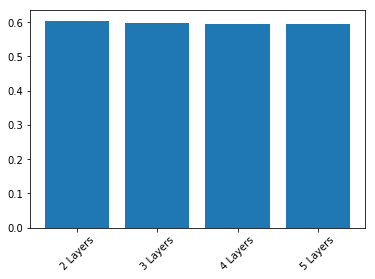

In [166]:
#Plot to show the best optimizer

score_list_reg_layers=[score_2l,score_3l, score_4l,score_5l]
names =['2 Layers','3 Layers','4 Layers', '5 Layers']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg_layers)), score_list_reg_layers)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

** Training without early stopping and Model Checkpoint and Sigmoid **

In [37]:
# Tensorflow model for Regression with sigmoid
model_reg_sig = Sequential()

model_reg_sig.add(Dense(25, input_dim=x_train_reg.shape[1], activation='sigmoid'))  
model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 2
model_reg_sig.add(Dense(1)) # Output


In [38]:
# Model training with sigmoid 
model_reg_sig.compile(loss='mean_squared_error', optimizer='adam')
model_reg_sig.fit(x_train_reg,y_train_reg,verbose=2,epochs=100)

Epoch 1/100
 - 1s - loss: 4.8183
Epoch 2/100
 - 0s - loss: 1.2602
Epoch 3/100
 - 0s - loss: 1.0508
Epoch 4/100
 - 0s - loss: 1.0352
Epoch 5/100
 - 0s - loss: 1.0107
Epoch 6/100
 - 0s - loss: 0.8989
Epoch 7/100
 - 0s - loss: 0.6185
Epoch 8/100
 - 0s - loss: 0.4155
Epoch 9/100
 - 0s - loss: 0.3205
Epoch 10/100
 - 0s - loss: 0.2761
Epoch 11/100
 - 0s - loss: 0.2525
Epoch 12/100
 - 0s - loss: 0.2386
Epoch 13/100
 - 0s - loss: 0.2292
Epoch 14/100
 - 0s - loss: 0.2220
Epoch 15/100
 - 0s - loss: 0.2168
Epoch 16/100
 - 0s - loss: 0.2119
Epoch 17/100
 - 0s - loss: 0.2075
Epoch 18/100
 - 0s - loss: 0.2031
Epoch 19/100
 - 0s - loss: 0.1997
Epoch 20/100
 - 0s - loss: 0.1963
Epoch 21/100
 - 0s - loss: 0.1936
Epoch 22/100
 - 0s - loss: 0.1913
Epoch 23/100
 - 0s - loss: 0.1882
Epoch 24/100
 - 0s - loss: 0.1856
Epoch 25/100
 - 0s - loss: 0.1840
Epoch 26/100
 - 0s - loss: 0.1818
Epoch 27/100
 - 0s - loss: 0.1800
Epoch 28/100
 - 0s - loss: 0.1784
Epoch 29/100
 - 0s - loss: 0.1768
Epoch 30/100
 - 0s - lo

In [39]:
# Predict stars
pred_reg_sig_simple = model_reg_sig.predict(x_test_reg)
print("Shape: {}".format(pred_reg_sig_simple.shape))

Shape: (2000, 1)


In [40]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sig_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 4.0, predicted Stars: [3.5908337]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 2.5, predicted Stars: [2.1344585]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 2.5, predicted Stars: [1.700152]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 3.5, predicted Stars: [3.765379]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 3.0, predicted Stars: [2.5106606]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 2.5, predicted Stars: [2.2755718]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [2.3116946]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 3.0, predicted Stars: [3.4402456]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 5.0, predicted Stars: [4.262379]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 2.5, predicted Stars: [3.265274]


In [41]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_sig = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sig_simple))
print("Final score (RMSE): {}".format(score_reg_sig))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sig_simple))

Final score (RMSE): 0.5019386410713196
R2 score: 0.75


** Training with early stopping and Model Checkpoint and Sigmoid **

In [168]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid.hdf5", verbose=1, save_best_only=True)

In [169]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_train_reg.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(1)) # Output
    model_reg_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 13s - loss: 2.3689 - val_loss: 1.1717

Epoch 00001: val_loss improved from inf to 1.17171, saving model to ./best_weights_sigmoid.hdf5
Epoch 2/100
 - 7s - loss: 1.0608 - val_loss: 1.0470

Epoch 00002: val_loss improved from 1.17171 to 1.04695, saving model to ./best_weights_sigmoid.hdf5
Epoch 3/100
 - 7s - loss: 1.0416 - val_loss: 1.0422

Epoch 00003: val_loss improved from 1.04695 to 1.04219, saving model to ./best_weights_sigmoid.hdf5
Epoch 4/100
 - 6s - loss: 1.0412 - val_loss: 1.0391

Epoch 00004: val_loss improved from 1.04219 to 1.03914, saving model to ./best_weights_sigmoid.hdf5
Epoch 5/100
 - 7s - loss: 1.0413 - val_loss: 1.0421

Epoch 00005: val_loss did not improve from 1.03914
Epoch 6/100
 - 7s - loss: 1.0411 - val_loss: 1.0428

Epoch 00006: val_loss did not improve from 1.03914
Epoch 7/100
 - 6s - loss: 1.0406 - val_loss: 1.0366

Epoch 00007: val_loss improved from 1.03914 to 1.03656, saving model to ./best_w


Epoch 00008: val_loss did not improve from 0.28336
Epoch 9/100
 - 7s - loss: 1.0407 - val_loss: 1.0498

Epoch 00009: val_loss did not improve from 0.28336
Epoch 10/100
 - 6s - loss: 1.0417 - val_loss: 1.0386

Epoch 00010: val_loss did not improve from 0.28336
Epoch 11/100
 - 7s - loss: 1.0411 - val_loss: 1.0480

Epoch 00011: val_loss did not improve from 0.28336
Epoch 00011: early stopping
7
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 15s - loss: 1.3308 - val_loss: 1.0326

Epoch 00001: val_loss did not improve from 0.28336
Epoch 2/100
 - 7s - loss: 0.9944 - val_loss: 0.8292

Epoch 00002: val_loss did not improve from 0.28336
Epoch 3/100
 - 7s - loss: 0.4161 - val_loss: 0.3283

Epoch 00003: val_loss did not improve from 0.28336
Epoch 4/100
 - 6s - loss: 0.2408 - val_loss: 0.2948

Epoch 00004: val_loss did not improve from 0.28336
Epoch 5/100
 - 7s - loss: 0.1948 - val_loss: 0.2896

Epoch 00005: val_loss did not improve from 0.28336
Epoch 6/100
 - 7s - loss: 0.1669 - 

In [170]:
# Predict stars
pred_reg_sig_stopping = model_reg_sig.predict(x_test_reg)
print("Shape: {}".format(pred_reg_sig_stopping.shape))

Shape: (2000, 1)


In [171]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg[i],pred_reg_sig_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 5.0, predicted Stars: [4.678062]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 3.5, predicted Stars: [3.4644246]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 3.5, predicted Stars: [3.7925215]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 5.0, predicted Stars: [4.6447577]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 2.5, predicted Stars: [2.710929]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 3.5, predicted Stars: [3.2405157]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 4.0, predicted Stars: [3.7411523]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 4.0, predicted Stars: [4.4633565]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 4.0, predicted Stars: [3.851685]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 4.5, predicted Stars: [4.5967903]


In [172]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_sig_stopping = np.sqrt(mean_squared_error(y_test_reg,pred_reg_sig_stopping))
print("Final score (RMSE): {}".format(score_reg_sig_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg, pred_reg_sig_stopping))

Final score (RMSE): 0.5323189496994019
R2 score: 0.73


** Training without early stopping and Model Checkpoint and Tanh **

In [173]:
#train test data
x_train_reg_tanh, x_test_reg_tanh, y_train_reg_tanh, y_test_reg_tanh = train_test_split(x_matrix_zscore, y_stars_regression , test_size=0.2)


In [174]:
# Tensorflow model for Regression with tanh
model_reg_tanh = Sequential()

model_reg_tanh.add(Dense(25, input_dim=x_train_reg_tanh.shape[1], activation='tanh'))  
model_reg_tanh.add(Dense(10, activation='tanh')) # Hidden 2
model_reg_tanh.add(Dense(1)) # Output


In [175]:
# Model training with sigmoid 
model_reg_tanh.compile(loss='mean_squared_error', optimizer='adam')
model_reg_tanh.fit(x_train_reg_tanh,y_train_reg_tanh,verbose=2,epochs=100)

Epoch 1/100
 - 10s - loss: 2.2030
Epoch 2/100
 - 3s - loss: 0.5618
Epoch 3/100
 - 3s - loss: 0.2565
Epoch 4/100
 - 3s - loss: 0.2242
Epoch 5/100
 - 3s - loss: 0.2096
Epoch 6/100
 - 3s - loss: 0.2014
Epoch 7/100
 - 3s - loss: 0.1950
Epoch 8/100
 - 3s - loss: 0.1904
Epoch 9/100
 - 3s - loss: 0.1848
Epoch 10/100
 - 3s - loss: 0.1799
Epoch 11/100
 - 3s - loss: 0.1755
Epoch 12/100
 - 3s - loss: 0.1713
Epoch 13/100
 - 3s - loss: 0.1677
Epoch 14/100
 - 3s - loss: 0.1639
Epoch 15/100
 - 3s - loss: 0.1597
Epoch 16/100
 - 2s - loss: 0.1569
Epoch 17/100
 - 3s - loss: 0.1545
Epoch 18/100
 - 2s - loss: 0.1515
Epoch 19/100
 - 2s - loss: 0.1490
Epoch 20/100
 - 3s - loss: 0.1462
Epoch 21/100
 - 3s - loss: 0.1446
Epoch 22/100
 - 2s - loss: 0.1418
Epoch 23/100
 - 3s - loss: 0.1403
Epoch 24/100
 - 3s - loss: 0.1378
Epoch 25/100
 - 3s - loss: 0.1352
Epoch 26/100
 - 3s - loss: 0.1334
Epoch 27/100
 - 2s - loss: 0.1308
Epoch 28/100
 - 2s - loss: 0.1278
Epoch 29/100
 - 2s - loss: 0.1256
Epoch 30/100
 - 3s - l

In [176]:
# Predict stars
pred_reg_tanh_simple = model_reg_tanh.predict(x_test_reg_tanh)
print("Shape: {}".format(pred_reg_tanh_simple.shape))

Shape: (2000, 1)


In [177]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg_tanh[i],pred_reg_tanh_simple[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 1.0, predicted Stars: [-2.400431]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.5, predicted Stars: [3.9455674]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 4.0, predicted Stars: [4.473979]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.0, predicted Stars: [3.137375]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 4.0, predicted Stars: [3.995518]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.9258718]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 1.5, predicted Stars: [2.004966]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.9783335]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 3.5, predicted Stars: [2.1402419]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3.0, predicted Stars: [2.7069018]


In [178]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_tanh = np.sqrt(mean_squared_error(y_test_reg_tanh,pred_reg_tanh_simple))
print("Final score (RMSE): {}".format(score_reg_tanh))
print('R2 score: %.2f' % r2_score(y_test_reg_tanh, pred_reg_tanh_simple))

Final score (RMSE): 0.7059175372123718
R2 score: 0.53


** Training with early stopping and Model Checkpoint and Tanh **

In [179]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh.hdf5", verbose=1, save_best_only=True)


In [180]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_train_reg_tanh.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(1)) # Output
    model_reg_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_train_reg_tanh,y_train_reg_tanh,validation_data=(x_test_reg_tanh,y_test_reg_tanh),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 10s - loss: 0.7349 - val_loss: 0.2445

Epoch 00001: val_loss improved from inf to 0.24450, saving model to ./best_weights_tanh.hdf5
Epoch 2/100
 - 3s - loss: 0.2329 - val_loss: 0.2387

Epoch 00002: val_loss improved from 0.24450 to 0.23867, saving model to ./best_weights_tanh.hdf5
Epoch 3/100
 - 3s - loss: 0.2105 - val_loss: 0.2417

Epoch 00003: val_loss did not improve from 0.23867
Epoch 4/100
 - 4s - loss: 0.1946 - val_loss: 0.2413

Epoch 00004: val_loss did not improve from 0.23867
Epoch 5/100
 - 4s - loss: 0.1818 - val_loss: 0.2399

Epoch 00005: val_loss did not improve from 0.23867
Epoch 00005: early stopping
1
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 13s - loss: 0.9725 - val_loss: 0.3077

Epoch 00001: val_loss did not improve from 0.23867
Epoch 2/100
 - 4s - loss: 0.2352 - val_loss: 0.2378

Epoch 00002: val_loss improved from 0.23867 to 0.23785, saving model to ./best_weights_tanh.hdf5
Epoch 3/

In [181]:
# Predict stars
pred_reg_tanh_stopping = model_reg_tanh.predict(x_test_reg_tanh)
print("Shape: {}".format(pred_reg_tanh_stopping.shape))

Shape: (2000, 1)


In [182]:
#Display 10 business

for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],y_test_reg_tanh[i],pred_reg_tanh_stopping[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 1.0, predicted Stars: [0.8637372]
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 4.5, predicted Stars: [4.230286]
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 4.0, predicted Stars: [3.9415882]
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 4.0, predicted Stars: [3.356799]
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 4.0, predicted Stars: [3.9985633]
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 4.0, predicted Stars: [3.7484093]
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 1.5, predicted Stars: [1.5690304]
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 5.0, predicted Stars: [4.9458656]
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 3.5, predicted Stars: [3.3346255]
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3.0, predicted Stars: [2.941024]


In [183]:
# Measure RMSE error.  RMSE is common for regression.
score_reg_tanh_stopping = np.sqrt(mean_squared_error(y_test_reg_tanh,pred_reg_tanh_stopping))
print("Final score (RMSE): {}".format(score_reg_tanh_stopping))
print('R2 score: %.2f' % r2_score(y_test_reg_tanh, pred_reg_tanh_stopping))

Final score (RMSE): 0.4864327609539032
R2 score: 0.78


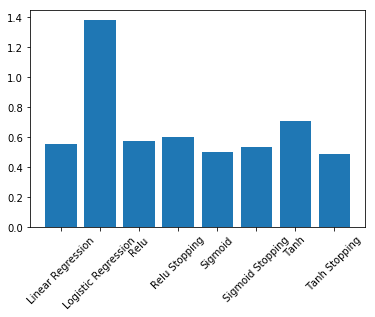

In [184]:
# plotting RMSE score for all regression models

score_list_reg=[score_lin_classic,score_log_classic,score_reg_relu,score_reg_relu_stopping,score_reg_sig,score_reg_sig_stopping,score_reg_tanh,score_reg_tanh_stopping]
names =['Linear Regression','Logistic Regression','Relu','Relu Stopping','Sigmoid','Sigmoid Stopping','Tanh','Tanh Stopping']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

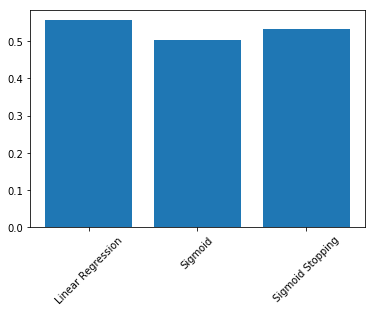

In [185]:
# plotting RMSE score for all regression models

score_list_reg=[score_lin_classic,score_reg_sig,score_reg_sig_stopping]
names =['Linear Regression','Sigmoid','Sigmoid Stopping']
tick_marks = np.arange(len(names))
plt.bar(range(len(score_list_reg)), score_list_reg)
plt.xticks(tick_marks, names, rotation=45)
plt.show()

# Training and Prediction for Classification

In [187]:
#train test data for linear regression

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, merge_df['encoded_stars'] , test_size=0.2, random_state=42)


** KNN **

In [188]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(x_train_lr, y_train_lr) 

y_pred_knn = knn.predict(x_test_lr)

In [189]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_knn[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 8
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 4
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 6
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 6
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 7
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 7
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 4
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 6


In [191]:
# Metrics
from sklearn import metrics

score_knn_acc = metrics.accuracy_score(y_test_lr, y_pred_knn)
print("Accuracy score: {}".format(score_knn_acc))

score_knn_precision = metrics.precision_score(y_test_lr, y_pred_knn, average= "weighted")
print("Precision score: {}".format(score_knn_precision))

score_knn_recall = metrics.recall_score(y_test_lr, y_pred_knn, average= "weighted")
print("Recall score: {}".format(score_knn_recall))

score_knn_f1 = metrics.f1_score(y_test_lr, y_pred_knn, average= "weighted")
print("F1 score: {}".format(score_knn_f1))

Accuracy score: 0.295
Precision score: 0.2960480875614052
Recall score: 0.295
F1 score: 0.2918900582503685


** SVM **

In [192]:
# SVM

svm_model = SVC(kernel="linear")

svm_model.fit(x_train_lr, y_train_lr)

y_pred_svm = svm_model.predict(x_test_lr)

In [193]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_svm[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 6
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 6
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 7
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 6
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 5
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 8
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 3
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 3


In [194]:
# Metrics

score_svm_acc = metrics.accuracy_score(y_test_lr, y_pred_svm)
print("Accuracy score: {}".format(score_svm_acc))

score_svm_precision = metrics.precision_score(y_test_lr, y_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision))

score_svm_recall = metrics.recall_score(y_test_lr, y_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall))

score_svm_f1 = metrics.f1_score(y_test_lr, y_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1))

Accuracy score: 0.4365
Precision score: 0.43072237226007926
Recall score: 0.4365
F1 score: 0.4278230138666609


** MNB **

In [195]:
mnb_model = MultinomialNB()

mnb_model.fit(x_train_lr, y_train_lr)

y_pred_mnb = mnb_model.predict(x_test_lr)

In [196]:
# list  the business with the stars and prediction

for i in range(0,10):
    idx=y_test_lr.index[i]
    print("business id - %s actual stars label - %d predicted - %d" 
          %(merge_df['business_id'][idx], y_test_lr[idx], y_pred_mnb[i]))

business id - hTF1Qo6PRFnDgg1rh9a9BQ actual stars label - 6 predicted - 8
business id - bAPjkuNJ67j2F4C5HQQHhQ actual stars label - 6 predicted - 6
business id - dFcs3q8ynbFEaAnbyGSLjQ actual stars label - 6 predicted - 6
business id - jrhc4s5XMR8S8kpGdU08og actual stars label - 7 predicted - 7
business id - e7207sqC-pSn6GIf31ikhQ actual stars label - 6 predicted - 6
business id - CF9TxeEdP5QxihYFAl4sUg actual stars label - 6 predicted - 8
business id - zZPCAFK85NtitSNVP_wfYg actual stars label - 5 predicted - 8
business id - 42U4Vlzr7nmQa1Bk8J4flw actual stars label - 8 predicted - 8
business id - TTrYd662CZFRPaiwl-sUqA actual stars label - 2 predicted - 3
business id - -lBIxCbHxuN3YO_sUkWeUQ actual stars label - 3 predicted - 0


In [197]:
# Metrics

score_mnb_acc = metrics.accuracy_score(y_test_lr, y_pred_mnb)
print("Accuracy score: {}".format(score_mnb_acc))

score_mnb_precision = metrics.precision_score(y_test_lr, y_pred_mnb, average= "weighted")
print("Precision score: {}".format(score_mnb_precision))

score_mnb_recall = metrics.recall_score(y_test_lr, y_pred_mnb, average= "weighted")
print("Recall score: {}".format(score_mnb_recall))

score_mnb_f1 = metrics.f1_score(y_test_lr, y_pred_mnb, average= "weighted")
print("F1 score: {}".format(score_mnb_f1))

Accuracy score: 0.3325
Precision score: 0.29977451126707483
Recall score: 0.3325
F1 score: 0.2831433707336793


# Tensorflow for Classification

**  Activation ReLU, Optimizer adam with stopping and checkpoint **

In [198]:
# Encoding stars 

hotcoded_stars_df = pd.get_dummies(merge_df['encoded_stars'], sparse = 'true')

In [199]:
y_stars_encoded = hotcoded_stars_df.values.astype(np.float32)

In [200]:
#train test data for classification

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, y_stars_encoded, test_size=0.2, random_state=42)


In [201]:
# set up checkpointer
checkpointer_classification = ModelCheckpoint(filepath="./best_weights_softmax.hdf5", verbose=1, save_best_only=True)

In [203]:
#Tensorflow classification
for i in range(10):
    print(i)
    
    # Build network
    model_classification = Sequential()
    model_classification.add(Dense(50, input_dim=x_train_lr.shape[1], activation='relu')) # Hidden 1
    model_classification.add(Dense(25, activation='relu')) # Hidden 2
    model_classification.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output
    model_classification.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model_classification.fit(x_train_lr,y_train_lr,validation_data=(x_test_lr,y_test_lr),callbacks=[monitor,checkpointer_classification],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_classification.load_weights('./best_weights_softmax.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 11s - loss: 1.7818 - val_loss: 1.4341

Epoch 00001: val_loss improved from inf to 1.43414, saving model to ./best_weights_softmax.hdf5
Epoch 2/100
 - 4s - loss: 1.3224 - val_loss: 1.2933

Epoch 00002: val_loss improved from 1.43414 to 1.29335, saving model to ./best_weights_softmax.hdf5
Epoch 3/100
 - 4s - loss: 1.1864 - val_loss: 1.2489

Epoch 00003: val_loss improved from 1.29335 to 1.24887, saving model to ./best_weights_softmax.hdf5
Epoch 4/100
 - 4s - loss: 1.1173 - val_loss: 1.2429

Epoch 00004: val_loss improved from 1.24887 to 1.24291, saving model to ./best_weights_softmax.hdf5
Epoch 5/100
 - 4s - loss: 1.0682 - val_loss: 1.2430

Epoch 00005: val_loss did not improve from 1.24291
Epoch 6/100
 - 4s - loss: 1.0262 - val_loss: 1.2564

Epoch 00006: val_loss did not improve from 1.24291
Epoch 7/100
 - 4s - loss: 0.9942 - val_loss: 1.2622

Epoch 00007: val_loss did not improve from 1.24291
Epoch 8/100
 - 4s - loss: 0.9


Epoch 00008: val_loss did not improve from 1.23126
Epoch 9/100
 - 4s - loss: 0.9025 - val_loss: 1.2947

Epoch 00009: val_loss did not improve from 1.23126
Epoch 00009: early stopping
8
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 12s - loss: 1.8677 - val_loss: 1.5608

Epoch 00001: val_loss did not improve from 1.23126
Epoch 2/100
 - 4s - loss: 1.3696 - val_loss: 1.3012

Epoch 00002: val_loss did not improve from 1.23126
Epoch 3/100
 - 4s - loss: 1.1994 - val_loss: 1.2525

Epoch 00003: val_loss did not improve from 1.23126
Epoch 4/100
 - 4s - loss: 1.1165 - val_loss: 1.2331

Epoch 00004: val_loss did not improve from 1.23126
Epoch 5/100
 - 4s - loss: 1.0612 - val_loss: 1.2454

Epoch 00005: val_loss did not improve from 1.23126
Epoch 6/100
 - 4s - loss: 1.0135 - val_loss: 1.2575

Epoch 00006: val_loss did not improve from 1.23126
Epoch 7/100
 - 4s - loss: 0.9700 - val_loss: 1.2670

Epoch 00007: val_loss did not improve from 1.23126
Epoch 8/100
 - 4s - loss: 0.9350 - va

In [205]:
pred_class = model_classification.predict(x_test_lr)
print("Shape: {}".format(pred_class.shape))
print(pred_class)

Shape: (2000, 9)
[[3.3878758e-05 9.1543414e-05 8.9627982e-04 ... 4.0991387e-01
  4.8678383e-02 6.5963869e-03]
 [6.9252616e-07 8.9822033e-06 1.5236050e-04 ... 4.3009984e-01
  5.8629435e-02 1.5350884e-03]
 [1.1523614e-06 2.7753495e-06 4.1048057e-05 ... 4.2310497e-01
  3.4682915e-01 9.0379909e-02]
 ...
 [1.4983370e-02 1.4174576e-01 3.0316588e-01 ... 1.3866302e-03
  8.1807193e-06 4.5280083e-07]
 [2.3610590e-02 3.7431344e-02 1.4308786e-01 ... 3.7967782e-02
  5.4452880e-03 1.0299933e-03]
 [1.4992657e-06 1.7870778e-05 2.5218487e-04 ... 4.5084012e-01
  4.1171301e-02 1.7219030e-03]]


In [206]:
predict_stars = np.argmax(pred_class,axis=1)
true_stars = np.argmax(y_test_lr,axis=1)

In [207]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars[i]))

1. Business ID: diaiQrxYFU1V5qxrFnW9fg, Actual Stars: 6, predicted Stars: 6
2. Business ID: TDTASGFy_aGp6vy0i23mDA, Actual Stars: 6, predicted Stars: 6
3. Business ID: VuKJ2s_JP8weQ54NfsXJXQ, Actual Stars: 6, predicted Stars: 6
4. Business ID: aGiBg2WKOpXS5-1DRnBiAQ, Actual Stars: 7, predicted Stars: 7
5. Business ID: ZMmgFw2P4LWsFXNn1ZGc1g, Actual Stars: 6, predicted Stars: 6
6. Business ID: sEKFq5u8P_s0-2mAZnx0JQ, Actual Stars: 6, predicted Stars: 6
7. Business ID: rYziPPEILDXJ_F5uKR--YQ, Actual Stars: 5, predicted Stars: 5
8. Business ID: Swm_uMOWNcJDZz5lXWyzKA, Actual Stars: 8, predicted Stars: 8
9. Business ID: 6nGnVP7M4qQRiclXxeqXSQ, Actual Stars: 2, predicted Stars: 3
10. Business ID: Tc24GX9-ZPr4_SHU0nJZZA, Actual Stars: 3, predicted Stars: 3


In [208]:
# Metrics

score_tf_acc_stopping = metrics.accuracy_score(true_stars, predict_stars)
print("Accuracy score: {}".format(score_tf_acc_stopping))

score_tf_precision_stopping = metrics.precision_score(true_stars, predict_stars, average= "weighted")
print("Precision score: {}".format(score_tf_precision_stopping))

score_tf_recall_stopping = metrics.recall_score(true_stars, predict_stars, average= "weighted")
print("Recall score: {}".format(score_tf_recall_stopping))

score_tf_f1_stopping = metrics.f1_score(true_stars, predict_stars, average= "weighted")
print("F1 score: {}".format(score_tf_f1_stopping))

Accuracy score: 0.495
Precision score: 0.49186543188663984
Recall score: 0.495
F1 score: 0.48906518574106805


** Classification with Sigmoid **

In [217]:
#train test data for classification

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_matrix_minmax, y_stars_encoded, test_size=0.2, random_state=42)


In [218]:
# set up checkpointer
checkpointer_classification_sig = ModelCheckpoint(filepath="./best_weights_softmax_sig.hdf5", verbose=1, save_best_only=True)

In [ ]:
#Tensorflow classification
for i in range(10):
    print(i)
    
    # Build network
    model_classification = Sequential()
    model_classification.add(Dense(50, input_dim=x_train_lr.shape[1], activation='sigmoid')) # Hidden 1
    model_classification.add(Dense(25, activation='sigmoid')) # Hidden 2
    model_classification.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output
    model_classification.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model_classification.fit(x_train_lr,y_train_lr,validation_data=(x_test_lr,y_test_lr),callbacks=[monitor,checkpointer_classification_sig],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_classification.load_weights('./best_weights_softmax_sig.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 12s - loss: 2.0552 - val_loss: 1.9931

Epoch 00001: val_loss improved from inf to 1.99312, saving model to ./best_weights_softmax_sig.hdf5
Epoch 2/100
 - 4s - loss: 1.9505 - val_loss: 1.8980

Epoch 00002: val_loss improved from 1.99312 to 1.89801, saving model to ./best_weights_softmax_sig.hdf5
Epoch 3/100
 - 5s - loss: 1.8194 - val_loss: 1.7438

Epoch 00003: val_loss improved from 1.89801 to 1.74384, saving model to ./best_weights_softmax_sig.hdf5
Epoch 4/100
 - 5s - loss: 1.6504 - val_loss: 1.5801

Epoch 00004: val_loss improved from 1.74384 to 1.58011, saving model to ./best_weights_softmax_sig.hdf5
Epoch 5/100
 - 5s - loss: 1.5100 - val_loss: 1.4736

Epoch 00005: val_loss improved from 1.58011 to 1.47360, saving model to ./best_weights_softmax_sig.hdf5
Epoch 6/100
 - 4s - loss: 1.4206 - val_loss: 1.4113

Epoch 00006: val_loss improved from 1.47360 to 1.41130, saving model to ./best_weights_softmax_sig.hdf5
Epoch 7/100

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 15s - loss: 2.0200 - val_loss: 1.9880

Epoch 00001: val_loss did not improve from 1.24380
Epoch 2/100
 - 4s - loss: 1.9327 - val_loss: 1.8668

Epoch 00002: val_loss did not improve from 1.24380
Epoch 3/100
 - 5s - loss: 1.7681 - val_loss: 1.6796

Epoch 00003: val_loss did not improve from 1.24380
Epoch 4/100
 - 4s - loss: 1.5873 - val_loss: 1.5286

Epoch 00004: val_loss did not improve from 1.24380
Epoch 5/100
 - 4s - loss: 1.4693 - val_loss: 1.4425

Epoch 00005: val_loss did not improve from 1.24380
Epoch 6/100
 - 4s - loss: 1.3932 - val_loss: 1.3908

Epoch 00006: val_loss did not improve from 1.24380
Epoch 7/100
 - 4s - loss: 1.3382 - val_loss: 1.3504

Epoch 00007: val_loss did not improve from 1.24380
Epoch 8/100
 - 4s - loss: 1.2952 - val_loss: 1.3241

Epoch 00008: val_loss did not improve from 1.24380
Epoch 9/100
 - 4s - loss: 1.2578 - val_loss: 1.3048

Epoch 00009: val_loss did not improve from 1.24380
Epoch 10/100
 -

In [ ]:
pred_softmax_sig = model_class.predict(x_test_lr)
print("Shape: {}".format(pred_softmax_sig.shape))
print(pred_softmax_sig)

In [ ]:
predict_stars = np.argmax(pred_softmax_sig,axis=1)
true_stars = np.argmax(y_test_lr,axis=1)

In [ ]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars[i]))

In [ ]:
# Metrics

score_acc_softmax_sig = metrics.accuracy_score(true_stars, predict_stars)
print("Accuracy score: {}".format(score_acc_softmax_sig))

score_precision_softmax_sig = metrics.precision_score(true_stars, predict_stars, average= "weighted")
print("Precision score: {}".format(score_precision_softmax_sig))

score_recall_softmax_sig = metrics.recall_score(true_stars, predict_stars, average= "weighted")
print("Recall score: {}".format(score_recall_softmax_sig))

score_f1_softmax_sig = metrics.f1_score(true_stars, predict_stars, average= "weighted")
print("F1 score: {}".format(score_f1_softmax_sig))

** Classification with Tanh **

In [ ]:
# set up checkpointer
checkpointer_classification_tanh = ModelCheckpoint(filepath="./best_weights_softmax_tanh.hdf5", verbose=1, save_best_only=True)

In [ ]:
#Tensorflow classification
for i in range(10):
    print(i)
    
    # Build network
    model_classification = Sequential()
    model_classification.add(Dense(50, input_dim=x_train_lr.shape[1], activation='tanh')) # Hidden 1
    model_classification.add(Dense(25, activation='tanh')) # Hidden 2
    model_classification.add(Dense(y_train_lr.shape[1], activation='softmax')) # Output
    model_classification.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model_classification.fit(x_train_lr,y_train_lr,validation_data=(x_test_lr,y_test_lr),callbacks=[monitor,checkpointer_classification_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_classification.load_weights('./best_weights_softmax_tanh.hdf5')

In [ ]:
pred_class_tanh = model_classification.predict(x_test_lr)
print("Shape: {}".format(pred_class_tanh.shape))
print(pred_class_tanh)

In [ ]:
predict_stars_tanh = np.argmax(pred_class_tanh,axis=1)
true_stars = np.argmax(y_test_lr,axis=1)

In [ ]:
for i in range(10):
    print("{}. Business ID: {}, Actual Stars: {}, predicted Stars: {}".format(i+1,merge_df['business_id'][2000+i],true_stars[i],predict_stars_tanh[i]))

In [ ]:
# Metrics

score_tf_acc_tanh = metrics.accuracy_score(true_stars, predict_stars_tanh)
print("Accuracy score: {}".format(score_tf_acc_tanh))

score_tf_precision_tanh = metrics.precision_score(true_stars, predict_stars_tanh, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh))

score_tf_recall_tanh = metrics.recall_score(true_stars, predict_stars_tanh, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh))

score_tf_f1_tanh = metrics.f1_score(true_stars, predict_stars_tanh, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh))

# Additional Features

In [225]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import Sequential

In [226]:
#train test data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_matrix_minmax, y_stars_regression , test_size=0.2)

In [227]:
#USe linear regression for regularization
model_regularization = Sequential()
model_regularization.add(Dense(50, input_dim=x_train_reg.shape[1], activation='relu'))
model_regularization.add(Dense(25, activation='relu'))
model_regularization.add(Dense(10, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu'))
model_regularization.add(Dense(1)) 
model_regularization.compile(loss='mean_squared_error', optimizer='adam')

In [228]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model_regularization.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor],verbose=2,epochs=100)

pred_regularization = model_regularization.predict(x_test_reg)

Train on 7981 samples, validate on 1996 samples
Epoch 1/100
 - 20s - loss: 4.3367 - val_loss: 2.2657
Epoch 2/100
 - 6s - loss: 1.7097 - val_loss: 1.3561
Epoch 3/100
 - 6s - loss: 1.1760 - val_loss: 1.0891
Epoch 4/100
 - 5s - loss: 0.9575 - val_loss: 0.9274
Epoch 5/100
 - 5s - loss: 0.8107 - val_loss: 0.8123
Epoch 6/100
 - 5s - loss: 0.6907 - val_loss: 0.7237
Epoch 7/100
 - 5s - loss: 0.5859 - val_loss: 0.6551
Epoch 8/100
 - 6s - loss: 0.4999 - val_loss: 0.6038
Epoch 9/100
 - 6s - loss: 0.4322 - val_loss: 0.5663
Epoch 10/100
 - 6s - loss: 0.3755 - val_loss: 0.5377
Epoch 11/100
 - 5s - loss: 0.3289 - val_loss: 0.5132
Epoch 12/100
 - 6s - loss: 0.2891 - val_loss: 0.4969
Epoch 13/100
 - 5s - loss: 0.2566 - val_loss: 0.4748
Epoch 14/100
 - 6s - loss: 0.2272 - val_loss: 0.4554
Epoch 15/100
 - 6s - loss: 0.2044 - val_loss: 0.4384
Epoch 16/100
 - 6s - loss: 0.1839 - val_loss: 0.4344
Epoch 17/100
 - 6s - loss: 0.1670 - val_loss: 0.4177
Epoch 18/100
 - 6s - loss: 0.1513 - val_loss: 0.4044
Epoch 

In [229]:
# Measure RMSE error.  RMSE is common for regression.
score_regularization = np.sqrt(metrics.mean_squared_error(pred_regularization,y_test_reg))
print("Final score (RMSE): {}".format(score_regularization))

Final score (RMSE): 0.5542775392532349


In [230]:
# Dropout

model_dropout = Sequential()
model_dropout.add(Dense(50, input_dim=x_train_reg.shape[1]))
model_dropout.add(Dropout(0.1))

model_dropout.add(Dense(25, activation='relu'))
model_dropout.add(Dense(10, activation='relu'))
model_dropout.add(Dense(1))

model_dropout.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_dropout.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),callbacks=[monitor],verbose=0,epochs=1000)

pred_dropout = model_dropout.predict(x_test_reg)

# Measure RMSE error.  RMSE is common for regression.
score_dropout = np.sqrt(metrics.mean_squared_error(pred_dropout,y_test_reg))
print("Final score (RMSE): {}".format(score_dropout))

Epoch 00017: early stopping
Final score (RMSE): 0.49788129329681396


In [231]:
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 50)                50100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_63 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 11        
Total params: 51,646
Trainable params: 51,646
Non-trainable params: 0
_________________________________________________________________


In [232]:
#Checking to see if regularization helps with over fitting when using postal code and categories and one hot coded values
#train test data
x_train_reg_ad, x_test_reg_ad, y_train_reg_ad, y_test_reg_ad = train_test_split(x_matrix_final, y_stars_regression , test_size=0.2)


In [238]:
#USe linear regression for regularization
model_regularization_ad = Sequential()
model_regularization_ad.add(Dense(50, input_dim=x_train_reg_ad.shape[1], activation='relu'))
model_regularization_ad.add(Dense(25, activation='relu'))
model_regularization_ad.add(Dense(10, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu'))
model_regularization_ad.add(Dense(1)) 
model_regularization_ad.compile(loss='mean_squared_error', optimizer='adam')

In [239]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model_regularization_ad.fit(x_train_reg_ad,y_train_reg_ad,validation_data=(x_test_reg_ad,y_test_reg_ad),callbacks=[monitor],verbose=2,epochs=100)

pred_regularization_ad = model_regularization_ad.predict(x_test_reg_ad)

Train on 7981 samples, validate on 1996 samples
Epoch 1/100
 - 18s - loss: 4.4570 - val_loss: 2.4116
Epoch 2/100
 - 6s - loss: 1.8795 - val_loss: 1.6409
Epoch 3/100
 - 5s - loss: 1.3024 - val_loss: 1.3105
Epoch 4/100
 - 6s - loss: 0.9978 - val_loss: 1.0954
Epoch 5/100
 - 5s - loss: 0.7967 - val_loss: 0.9675
Epoch 6/100
 - 6s - loss: 0.6554 - val_loss: 0.8644
Epoch 7/100
 - 5s - loss: 0.5439 - val_loss: 0.7992
Epoch 8/100
 - 6s - loss: 0.4576 - val_loss: 0.7301
Epoch 9/100
 - 5s - loss: 0.3906 - val_loss: 0.6778
Epoch 10/100
 - 6s - loss: 0.3365 - val_loss: 0.6339
Epoch 11/100
 - 5s - loss: 0.2923 - val_loss: 0.6078
Epoch 12/100
 - 6s - loss: 0.2562 - val_loss: 0.5776
Epoch 13/100
 - 6s - loss: 0.2272 - val_loss: 0.5579
Epoch 14/100
 - 6s - loss: 0.2018 - val_loss: 0.5334
Epoch 15/100
 - 5s - loss: 0.1801 - val_loss: 0.5166
Epoch 16/100
 - 6s - loss: 0.1625 - val_loss: 0.5018
Epoch 17/100
 - 5s - loss: 0.1473 - val_loss: 0.4803
Epoch 18/100
 - 6s - loss: 0.1350 - val_loss: 0.4686
Epoch 

In [240]:
# Measure RMSE error.  RMSE is common for regression.
score_regularization_ad = np.sqrt(metrics.mean_squared_error(pred_regularization_ad,y_test_reg_ad))
print("Final score (RMSE): {}".format(score_regularization_ad))

Final score (RMSE): 0.5967134833335876


In [244]:
# Dropout

model_dropout_ad = Sequential()
model_dropout_ad.add(Dense(50, input_dim=x_train_reg_ad.shape[1]))
model_dropout_ad.add(Dropout(0.1))

model_dropout_ad.add(Dense(25, activation='relu'))
model_dropout_ad.add(Dense(10, activation='relu'))
model_dropout_ad.add(Dense(1))

model_dropout_ad.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_dropout_ad.fit(x_train_reg_ad,y_train_reg_ad,validation_data=(x_test_reg_ad,y_test_reg_ad),callbacks=[monitor],verbose=0,epochs=1000)

pred_dropout_ad = model_dropout_ad.predict(x_test_reg_ad)

# Measure RMSE error.  RMSE is common for regression.
score_dropout_ad = np.sqrt(metrics.mean_squared_error(pred_dropout_ad,y_test_reg_ad))
print("Final score (RMSE): {}".format(score_dropout_ad))

Epoch 00009: early stopping
Final score (RMSE): 0.6171209812164307


In [245]:
model_dropout_ad.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 50)                275400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_87 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 11        
Total params: 276,946
Trainable params: 276,946
Non-trainable params: 0
_________________________________________________________________
